In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import unicodedata
import re

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as ds
from torchvision import models, transforms, utils, datasets
from torch.utils import data
from torchsummary import summary
from torch.optim import lr_scheduler

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import requests
from urllib.request import urlopen

from PIL import Image

from WebScraping import search_and_download

## Read In

In [2]:
fish_df = pd.read_csv("data/fish_df.csv")

# Scrape Images Using Selenium

In [3]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

for ind, row in fish_df.iterrows():
    searchterm_reg_name = row["FishBase name"]
    searchterm_sci_name = row["Species"]
    save_folder = str(row["fishbase_id"])
    number_images = 500
    target_path = '/media/shivaram/SharedVolum/Projects/FishID/scraped_images/' 
    
    if os.path.exists(target_path + "scientific/" + save_folder):
        continue
    else:
        print(f"Working on {searchterm_reg_name} ({searchterm_sci_name})")
    
    if searchterm_reg_name == searchterm_reg_name:
        search_and_download(searchterm_reg_name, "regular/" + save_folder , driver = driver, number_images=number_images)
    if searchterm_sci_name == searchterm_sci_name:
        search_and_download(searchterm_sci_name, "scientific/" + save_folder, driver = driver, number_images=number_images)



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Driver [/home/shivaram/.wdm/drivers/chromedriver/linux64/101.0.4951.41/chromedriver] found in cache


# Filter Images for Not Fish
My IsFish model was built on a somewhat controlled dataset (mini-imagenet and fishbase images). As a result, it will naturally perform more poorly on this real world data. To get a better understanding of its performance, I preview the classifications as well as the model's confidence in them. In doing so, I learned a few things, namely that:
- The model seems to struggle with maps and text images with images within them. 
- Lowering the threshold to -1 or -.5 (instead of 0) for the deltas decreases the number of false negatives while minimally increasing the false positives. 

Based on these findings, I decided to add some images of maps to the IsFish Classifier and retrain it. 

In [6]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load("models/is_fish.pt"))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), ]) #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
regular_path = "/media/shivaram/SharedVolum/Projects/FishID/scraped_images/scientific" 
# For each species folder
i = 0
with torch.no_grad():
    for folder in os.listdir(regular_path):
        print(f"Species {folder}")
        if i == 0:
            break
        
        # For each image in species folder
        fish_count = 0
        not_fish_count = 0
        deltas = []
        for file in os.listdir(regular_path + "/" + folder):
            image_path = regular_path + "/" + folder + "/" + file
            try:
                img = Image.open(image_path).convert('RGB')
            except:
                continue
            img_filt = data_transforms(img).cuda().unsqueeze(0)
            outputs = model_ft(img_filt)
            
            _, preds =torch.max(outputs, 1)
            preds = preds.tolist()
            delta = outputs.tolist()[0][0] - outputs.tolist()[0][1]
            preds = preds[0]
            
            if preds == 0:
                fish_count += 1
                print(delta)
                display(img)
                
            else:
                not_fish_count += 1
                #if delta < -1.5:
                #  display(image)
                deltas.append(delta)
            

        i += 1
        print(fish_count)
        print(not_fish_count)
        print(deltas)



Species 972


(array([ 2.,  1.,  3.,  4.,  5.,  7.,  5.,  6.,  4.,  8., 12.,  9., 11.,
        15., 15., 16., 24., 16., 20., 15.]),
 array([-7.8954854 , -7.50132999, -7.10717458, -6.71301917, -6.31886376,
        -5.92470835, -5.53055294, -5.13639753, -4.74224212, -4.34808671,
        -3.9539313 , -3.55977589, -3.16562048, -2.77146507, -2.37730966,
        -1.98315425, -1.58899884, -1.19484343, -0.80068802, -0.40653261,
        -0.0123772 ]),
 <BarContainer object of 20 artists>)

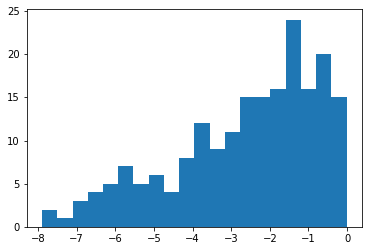

In [18]:
from matplotlib import pyplot as plt
plt.hist(deltas, 20)

In [8]:
"""

dataLoader = torch.utils.data.DataLoader(image_dataset, batch_size=64, num_workers=4)"""

'data_transforms = transforms.Compose([transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])\nimage_dataset = datasets.ImageFolder("data/fishbase_images/",data_transforms)\ndataLoader = torch.utils.data.DataLoader(image_dataset, batch_size=64, num_workers=4)'

# References
- https://medium.com/geekculture/scraping-images-using-selenium-f35fab26b122
- https://stackoverflow.com/questions/10543940/check-if-a-url-to-an-image-is-up-and-exists-in-python
https://stackoverflow.com/questions/295135/turn-a-string-into-a-valid-filename